# A


In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

df = pd.read_csv("test.csv", sep = "\t", header = None, index_col = 0)

stock = input('Input stock symbol')
df = df.loc[stock]

print(df)
print("Number of rows and columns:", df.shape)

split_ind = math.floor(0.8*df.shape[0])
training_set = df.iloc[:split_ind].values
test_set = df.iloc[split_ind:].values

print(training_set.shape)
print(test_set.shape)

Input stock symbola
1       11.144
2       10.471
3       10.828
4       10.698
5       10.910
         ...  
3646    68.220
3647    68.250
3648    68.110
3649    67.470
3650    66.810
Name: a, Length: 3650, dtype: float64
Number of rows and columns: (3650,)
(2920,)
(730,)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set.reshape(-1,1))

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, training_set.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(2860, 60)
(2860,)
(2860, 60, 1)
(2860,)


In [ ]:
model = Sequential()#Adding the first LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))# Adding a second LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))# Adding a third LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))# Adding a fourth LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50))
model.add(Dropout(0.2))# Adding the output layer

model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
90/90 [==============================] - 17s 119ms/step - loss: 0.0179
Epoch 2/10
90/90 [==============================] - 10s 113ms/step - loss: 0.0046
Epoch 3/10
90/90 [==============================] - 11s 122ms/step - loss: 0.0047
Epoch 4/10
90/90 [==============================] - 11s 123ms/step - loss: 0.0038
Epoch 5/10
90/90 [==============================] - 12s 132ms/step - loss: 0.0031
Epoch 6/10
90/90 [==============================] - 11s 125ms/step - loss: 0.0034
Epoch 7/10
90/90 [==============================] - 11s 126ms/step - loss: 0.0031
Epoch 8/10
90/90 [==============================] - 11s 121ms/step - loss: 0.0031
Epoch 9/10
90/90 [==============================] - 10s 113ms/step - loss: 0.0025
Epoch 10/10
90/90 [==============================] - 11s 119ms/step - loss: 0.0027


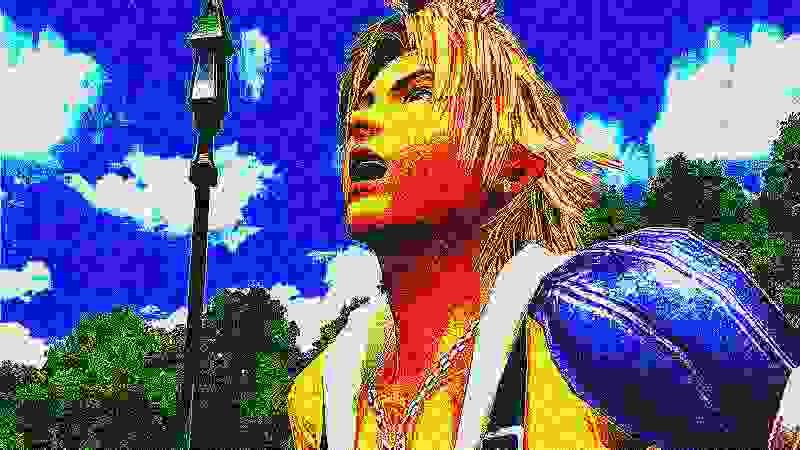

In [ ]:
# Using the created model
dataset_train = df.iloc[:split_ind]
dataset_test = df.iloc[split_ind:]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
print(dataset_total.shape)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

print(inputs.shape)

X_test = []
for i in range(60 , inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(3650,)
(790, 1)
(730, 60, 1)


In [ ]:
# Get predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

print(predicted_stock_price.shape)

(730, 1)


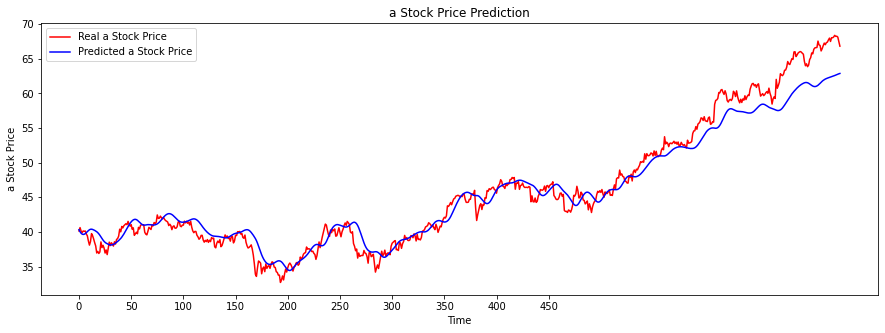

In [ ]:
# Visualising the results
plt.figure(figsize=(15, 5))
plt.plot(np.arange(0,len(dataset_test),1), dataset_test.values, color = 'red', label = 'Real ' + stock + ' Stock Price')
plt.plot(np.arange(0,len(dataset_test),1), predicted_stock_price, color = 'blue', label = 'Predicted ' + stock + ' Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title(stock + ' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(stock + ' Stock Price')
plt.legend()
plt.show()



---





# B


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')
df.head()

train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(7752, 30, 1)


In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 13s 45ms/step - loss: 0.1736 - val_loss: 0.2234
Epoch 2/10
218/218 [==============================] - 9s 40ms/step - loss: 0.1018 - val_loss: 0.1827
Epoch 3/10
218/218 [==============================] - 8s 39ms/step - loss: 0.1004 - val_loss: 0.1607
Epoch 4/10
218/218 [==============================] - 8s 38ms/step - loss: 0.1181 - val_loss: 0.2432
Epoch 5/10
218/218 [==============================] - 8s 39ms/step - loss: 0.1260 - val_loss: 0.3079
Epoch 6/10
218/218 [==============================] - 9s 41ms/step - loss: 0.1203 - val_loss: 0.3100
Epoch 7/10
218/218 [==============================] - 8s 39ms/step - loss: 0.1147 - val_loss: 0.1525
Epoch 8/10
218/218 [==============================] - 8s 39ms/step - loss: 0.1056 - val_loss: 0.1747
Epoch 9/10
218/218 [==============================] - 8s 38ms/step - loss: 0.1276 - val_loss: 0.1364
Epoch 10/10
218/218 [==============================] - 8s 38ms/step - loss: 0.1250 - val_l

In [ ]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close
anomalies = test_score_df[test_score_df.anomaly == True]

anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2017-10-26,0.652002,0.65,True,2.940375
2017-10-27,0.656868,0.65,True,2.979199
2017-10-30,0.656322,0.65,True,2.963722
2017-10-31,0.659060,0.65,True,2.968286
2017-11-01,0.663366,0.65,True,2.975987


(170,)
(170, 1)


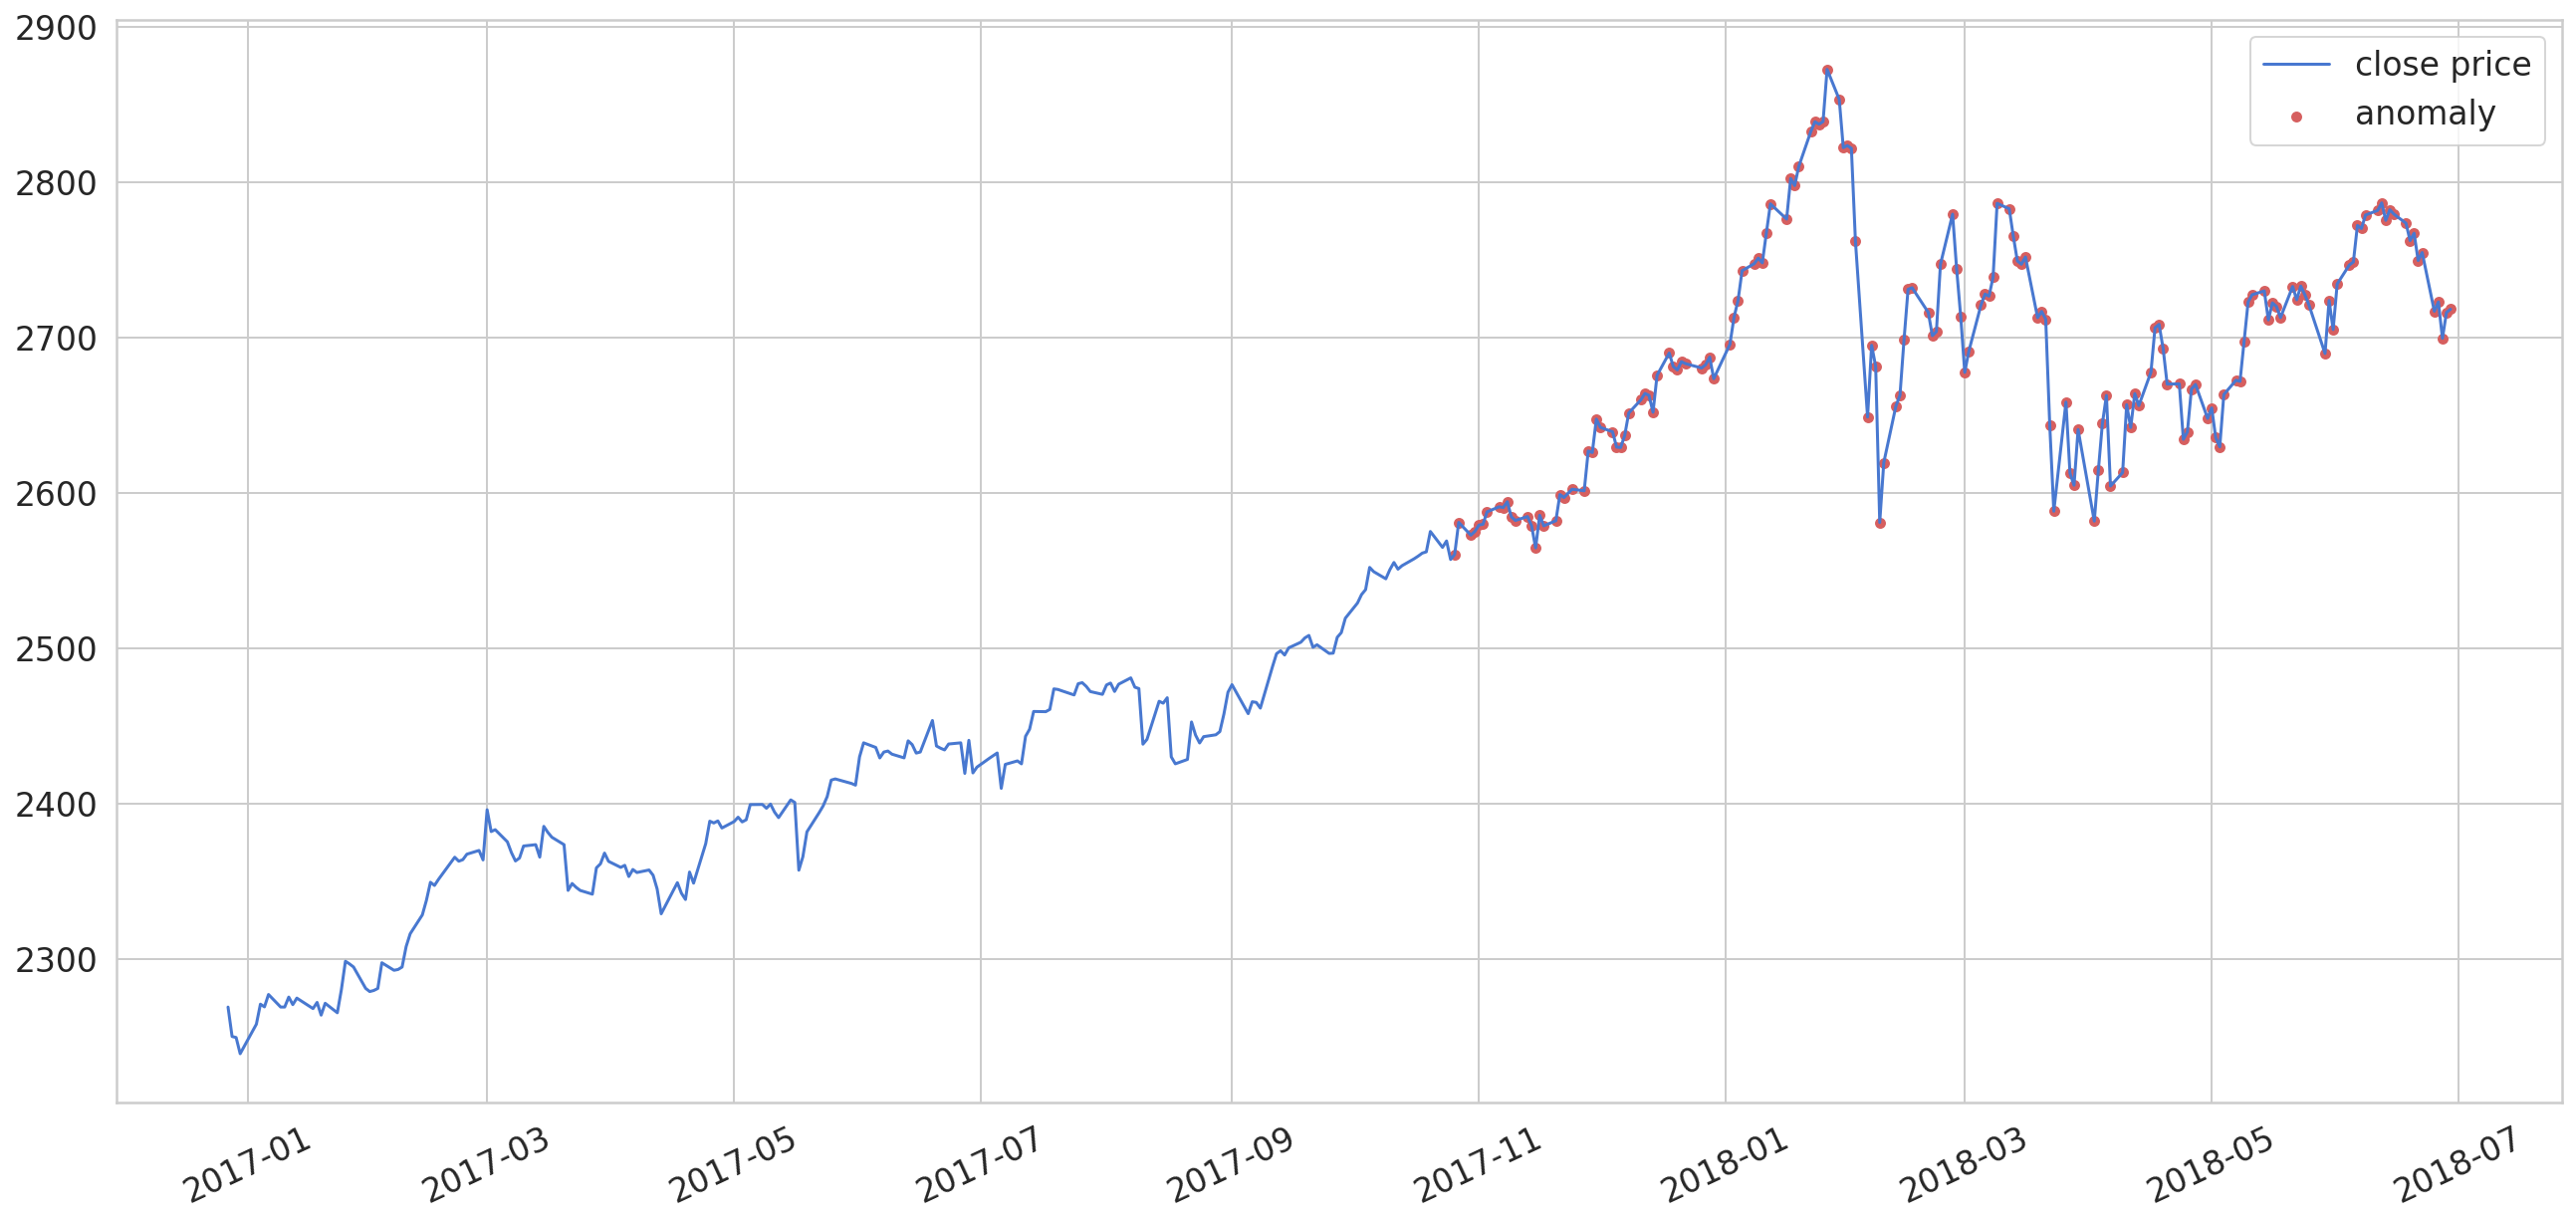

In [ ]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close.values.reshape(-1,1)), 
  label='close price'
)

plt.scatter(
  anomalies.index,
  scaler.inverse_transform(anomalies.close.values.reshape(-1,1)),
  color=sns.color_palette()[3],
  s=20,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

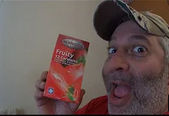